In [4]:
import os 
import json
import pprint
import pandas as pd
from pandas import json_normalize
import numpy as np

from IPython.display import display
#from gnuplotlib import gp
import matplotlib.pyplot as plt
import autogpy
import seaborn as sns


C:\Users\larad\AppData\Local\Temp\ipykernel_43300\549442779.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [68]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
sns.set_style("white")



def parseQlogFile(qlog_file_path, regex):
    f = open(qlog_file_path, 'r')
    qlog_data = f.read()
    f.close()

    records = qlog_data.strip().split(regex)
    parsedRecords = parseQlogDataRecords(records)
    #pprint.pprint(parsedRecords)
    #data_dict = createDictionary(parsedRecords)
    transport_records = [record for record in parsedRecords[1:] if 'packet_sent' in record["name"] or 'packet_received' in record["name"]]
    parameters_set_records = [record for record in parsedRecords[1:] if 'parameters_set' in record["name"]]
    #pprint.pprint(transport_records)
    #displayPandasTable(parsedRecords)
    #df = pd.DataFrame(parsedRecords[1:]).fillna('')
    #mux = pd.MultiIndex.from_tuples(r["data"].keys() for r in transport_records)
    #df = pd.DataFrame(list(r["data"].values() for r in transport_records), index=mux).fillna('')
    #display(df)
    connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer = getHandshakeTimes(transport_records)
    error_reason = getError(transport_records)
    tls_established = getTLSInfo(parameters_set_records)
    zeroRTT = get0RTTPackets(transport_records)
    if zeroRTT > 0:
        print(zeroRTT)

    return connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer, error_reason, tls_established


def getHandshakeTimes(records):
    initial_packet_time = records[0]["time"]
    all_handshake_end_time = 0
    tls_handshake_packets, connection_establishment_handshake_packets = getHandshakePackets(records)

    # Get time of first data packet:
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type != "initial" and packet_type != "handshake":
            all_handshake_end_time = record["time"]
            break
    
    if len(connection_establishment_handshake_packets) == 0:
        return (None, None, None)
    # Get time of first data packet after connection establishment handshake:
    connection_establishment_handshake_start_time = connection_establishment_handshake_packets[0]["time"]
    connection_establishment_handshake_end_time = connection_establishment_handshake_packets[-1]["time"]
    

    if len(tls_handshake_packets) == 0:
        return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, None, None)
    # Get time of first data packet after TLS handshake:
    tls_handshake_start_time = tls_handshake_packets[0]["time"]
    tls_handshake_end_time = tls_handshake_packets[-1]["time"]
    
    # Get number of different packet types to check if connection was established
    packet_types = {}
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        
        if packet_type not in packet_types:
            packet_types[packet_type] = 1
        else:
            packet_types[packet_type] += 1
    
    if len(packet_types.keys()) == 1:
        #print("No connection was established.")
        return None
    else:
        #print("Transport Packet Types: ", packet_types)
        #print("Time to Complete Handshake: ", handshake_end_time - initial_packet_time, "ms")
        #print("\n\n")
        #print("time from initial to end of tls handshake:", tls_handshake_end_time - initial_packet_time)
        #print("duration of tls handshake: ", tls_handshake_end_time - tls_handshake_start_time)
        
        #print("time from initial to end of ce handshake:", connection_establishment_handshake_end_time - initial_packet_time)
        #print("duration of ce handshake: ", connection_establishment_handshake_end_time - connection_establishment_handshake_start_time)
        #print(max(connection_establishment_handshake_end_time - initial_packet_time, tls_handshake_end_time - initial_packet_time))
        return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, 
                tls_handshake_end_time - tls_handshake_start_time, 
                #max(connection_establishment_handshake_end_time - initial_packet_time, tls_handshake_end_time - initial_packet_time))
                all_handshake_end_time - initial_packet_time)

def getHandshakePackets(records):
    tls_handshake_packets = []
    connection_establishment_handshake_packets = []

    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type == "handshake":
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "crypto":
                    #print("TLS PACKET")
                    #pprint.pprint(record)
                    tls_handshake_packets.append(record)
                else:
                    #print("CONNECTION ESTABLISHMENT PACKET")
                    #pprint.pprint(record)
                    connection_establishment_handshake_packets.append(record)
    return tls_handshake_packets, connection_establishment_handshake_packets


def getError(records):
    error_reason = ""
    for record in records:
        if "frames" in record["data"]:
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "connection_close":
                    error_reason = frame["reason"]
                    break
    return error_reason

def getTLSInfo(records):
    tls_ciphers = []
    for record in records:
        if "tls_cipher" in record["data"]:
            tls_ciphers.append(record["data"]["tls_cipher"])
    return tls_ciphers

def get0RTTPackets(records):
    num_of_0RTT_packets = 0
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type == "0RTT":
            num_of_0RTT_packets += 1
    return num_of_0RTT_packets

def parseQlogDataRecords(qlog_data):
   json_data = [json.loads(string.strip()) for string in qlog_data]
   return json_data

def createDictionary(parsed_data):
    data_dict = {}

    for data in parsed_data:
        if type(data) == dict:
            for key, value in data.items():
                if key not in data_dict:
                    data_dict[key] = [value]
                else:
                    if type(value) == dict:
                        data_dict[key].append(createDictionary(value))
                    else:
                        data_dict[key].append(value)
        else:
            return parsed_data

    
    #pprint.pprint(data_dict)
    return data_dict

def displayPandasTable(parsedRecords):

    flattened_header_data = createDictionary(parsedRecords[0])
    flattened_header_data2 = createDictionary(parsedRecords[1])
    flattened_data = createDictionary(parsedRecords[1:])

    #pprint.pprint(flattened_data)
            
    # Create DataFrame from flattened data
    #df = pd.DataFrame(parsedRecords)
    #df = pd.concat({k: pd.DataFrame(v).T for k, v in data_dict.items()}, axis=0)
    df1 = pd.DataFrame(flattened_header_data)
    df2 = pd.DataFrame(flattened_header_data2)
    df2 = pd.DataFrame(flattened_header_data2)
    #df = pd.DataFrame({k: [flattened_data.get(k, None)] for k in keys})
    df = pd.DataFrame(flattened_data)

    df = df.fillna('')
    # Display DataFrame
    #df = json_normalize(df)
    #df = pd.MultiIndex.from_frame(df)
    #df.to_flat_index()
    
    display(df1)
    display(df2)
    display(df)
    

def getMeanTime(times):
    return np.mean([time for time in times if time != None])

def generateHandshakeTimeDistribution(handshake_data, plot_type, handshake_type="", proto="", title=""):
    bins = []
    data = {"home":{"urls": [], "times":[]}, "campus": {"urls": [], "times":[]}}
    for location in handshake_data:
        max_time = 0
        for url,time in handshake_data[location].items():
            if time != None:
                data[location]["urls"].append(url)
                data[location]["times"].append(time)
                
                if time > max_time:
                    max_time = time
        bins.append(int(max_time // 5))
    print(bins)
    if plot_type == 1:
        showHistPlot1(data, bins, handshake_type, proto)
    elif plot_type == 2:
        showHistPlot2(data, bins, title)

    
def showHistPlot1(data, bins, handshake_type, proto):    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True, dpi=100)
    
    sns.histplot(data["home"]["times"], color="dodgerblue", label="home", bins=bins[0], ax=axes[0], legend=True, kde=True) #log_scale=True
    axes[0].set_title('Measurements taken from home')
    axes[0].set_xlabel('Handshake Time (ms)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    sns.histplot(data["campus"]["times"], color="deeppink", label="campus", bins=bins[1], ax=axes[1], legend=True, kde=True) #log_scale=True
    axes[1].set_title('Measurements taken from campus')
    axes[1].set_xlabel('Handshake Time (ms)')
    axes[1].grid(True)

    # Set x-axis limit for both subplots
    x_limit = 100  # Example limit
    axes[0].set_xlim(0, x_limit)
    axes[1].set_xlim(0, x_limit)

    # Set x-axis limit for both subplots
    y_limit = 150  # Example limit
    axes[0].set_ylim(0, y_limit)
    axes[1].set_ylim(0, y_limit)



    plt.suptitle(f'Time taken to complete {handshake_type} Handshake using {proto}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def showHistPlot2(data, bins, title):    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True, dpi=100)
    
    sns.histplot(data["home"]["times"], color="orange", label="home", bins=bins[0], ax=axes[0], legend=True, kde=True) #log_scale=True
    axes[0].set_title('Measurements taken from home')
    axes[0].set_xlabel('Handshake Time (ms)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    sns.histplot(data["campus"]["times"], color="purple", label="campus", bins=bins[1], ax=axes[1], legend=True, kde=True) #log_scale=True
    axes[1].set_title('Measurements taken from campus')
    axes[1].set_xlabel('Handshake Time (ms)')
    axes[1].grid(True)

    # Set x-axis limit for both subplots
    x_limit = 500  # Example limit
    axes[0].set_xlim(0, x_limit)
    axes[1].set_xlim(0, x_limit)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def getTLSErrors(error_reasons):
    data = {"home":{"urls": [], "errors":[]}, "campus": {"urls": [], "errors":[]}}
    count_errors = {"home":{}, "campus":{}}
    for location in error_reasons:
        for k, v in error_reasons[location].items():
            if v != '':
                data[location]["urls"].append(k)
                data[location]["errors"].append(v)
                if v in count_errors[location]:
                    count_errors[location][v].append(k)
                else: 
                    count_errors[location][v] = [k]
    
    total_urls = {"home":917, "campus":920}
    for location in count_errors:
        print("\n\nErrors for location: ", location)
        for error in count_errors[location]:
            print("\nNumber of errors with message", error, ": ", len(count_errors[location][error]))
            print((len(count_errors[location][error])/total_urls[location]) * 100, "% of all errors")


def getTLSEstablishedInfo(tls_established):
    data = {"home":{"urls": [], "tls_cipher":[]}, "campus": {"urls": [], "tls_cipher":[]}}
    tls_ciphers = {"home": {}, "campus":{}}
    for location in tls_established:
        for k, v in tls_established[location].items():
            data[location]["urls"].append(k)
            data[location]["tls_cipher"] = v
            for cipher in v:
                if cipher != None:
                    if cipher in tls_ciphers[location]:
                        tls_ciphers[location][cipher].append(k)
                    else:
                        tls_ciphers[location][cipher] = [k]

    total_urls = {"home":917, "campus":920}
    for location in tls_ciphers:
        print("\n\Ciphers for location: ", location)
        for cipher in tls_ciphers[location]:
            print("\nNumber of cipher ", cipher, ": ", len(tls_ciphers[location][cipher]))
            print((len(tls_ciphers[location][cipher])/total_urls[location]) * 100, "% of all urls have this cipher")

In [69]:
# Global variable declarations
regex = chr(30)

locations = ["home", "campus"]

handshake_times = {l:{} for l in locations}
tls_handshake_times = {l:{} for l in locations}

time_to_data_transfer = {l:{} for l in locations}

error_reasons = {l:{} for l in locations}
tls_established = {l:{} for l in locations}

In [70]:
current_location = locations[0]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break


In [71]:
current_location = locations[1]

# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break

[39, 17]


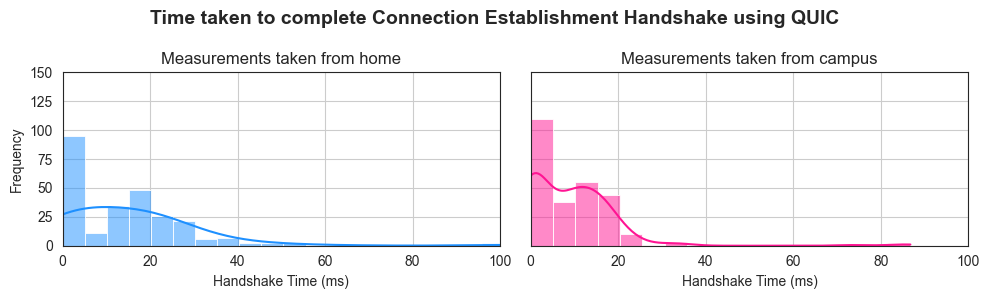

[27, 17]


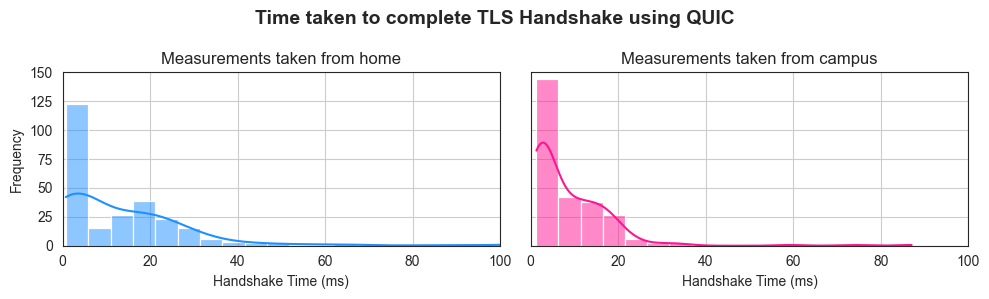

[95, 210]


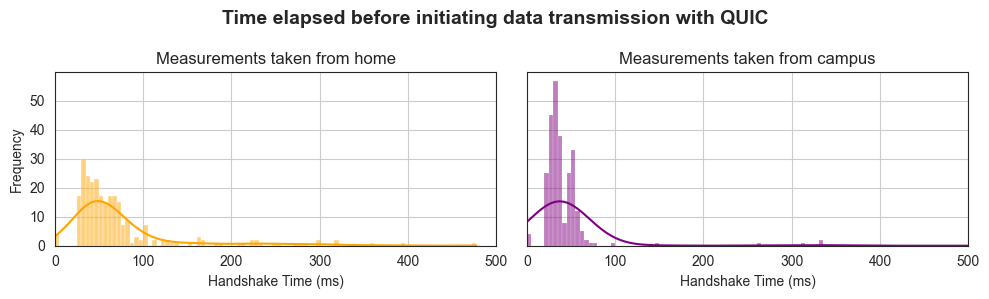



Errors for location:  home

Number of errors with message kthxbye :  257
28.02617230098146 % of all errors

Number of errors with message 200:TLS handshake failure (ENCRYPTION_INITIAL) 80: internal error :  155
16.90294438386041 % of all errors

Number of errors with message handshake failed :  2
0.21810250817884408 % of all errors

Number of errors with message 28:Reject connection :  1
0.10905125408942204 % of all errors

Number of errors with message TLS alert 80 :  1
0.10905125408942204 % of all errors

Number of errors with message 28:TLS handshake failure (ENCRYPTION_INITIAL) 40: handshake failure :  2
0.21810250817884408 % of all errors


Errors for location:  campus

Number of errors with message handshake failed :  3
0.32608695652173914 % of all errors

Number of errors with message kthxbye :  256
27.82608695652174 % of all errors

Number of errors with message 200:TLS handshake failure (ENCRYPTION_INITIAL) 80: internal error :  148
16.08695652173913 % of all errors

Number 

In [20]:
#print("Average time to complete handshake: ", getMeanTime(handshake_times), "ms")
#generateHandshakeTimeDistribution(handshake_times)
generateHandshakeTimeDistribution(handshake_times, 1, "Connection Establishment", "QUIC")
generateHandshakeTimeDistribution(tls_handshake_times, 1, "TLS", "QUIC")
generateHandshakeTimeDistribution(time_to_data_transfer, 2, title="Time elapsed before initiating data transmission with QUIC")

getTLSErrors(error_reasons)
getTLSEstablishedInfo(tls_established)

In [7]:


"""
TLS:

parameters_set
key_updated & key_discarded : tls can trigger
crypto_error

packet_received, raw, frames -> [{frame_type: "connection_close", "reason": "CONTAINS TLS"}]
handshake_failure: Indicates that the sender was unable to negotiate an acceptable set of security parameters 
given the options available. This is a fatal error.

internal_error: An internal error unrelated to the peer or the correctness of the protocol makes it impossible 
to continue, such as a memory allocation failure. The error is not related to protocol. 
This message is always fatal.

"""

'\nTLS:\n\nparameters_set\nkey_updated & key_discarded : tls can trigger\ncrypto_error\n\npacket_received, raw, frames -> [{frame_type: "connection_close", "reason": "CONTAINS TLS"}]\nhandshake_failure: Indicates that the sender was unable to negotiate an acceptable set of security parameters \ngiven the options available. This is a fatal error.\n\ninternal_error: An internal error unrelated to the peer or the correctness of the protocol makes it impossible \nto continue, such as a memory allocation failure. The error is not related to protocol. \nThis message is always fatal.\n\n'

In [11]:
import dpkt
from scapy.all import *
import libpcap
#from scapy.ssl_tls import *
#from scapy_ssl_tls.ssl_tls import *



In [38]:
def parsePcapFile(path):
    packets = rdpcap(path)
    #f = open(path,'r', errors="ignore")
    #pcap_data = f.read()
    
    #client_ip = packets[IP].src
    #server_ip = packets[IP].dst
    
    #print(client_ip, server_ip)

    #sessions = packets.sessions()
    #for pkt in packets:
        #print(pkt.summary())
        #print(pkt.show())
    handshake_time = findHandshakeTime(packets)
    tls_packets = findTLSPackets(packets)
    #pprint.pprint(tls_packets)
    #print(handshake_time)
    return handshake_time, tls_packets

def findHandshakeTime(packets):
    handshake_complete = False
    initial_time = packets[0].time
    for pkt in packets:
        #print(pkt.summary())
        #print(pkt.src, pkt.dst, pkt.proto, pkt.time)
        #pprint.pprint(pkt.payload)
        if handshake_complete:
            total_handshake_time = (float(pkt.time) - initial_time) * 1000
            if total_handshake_time < 0:
                return None
            return total_handshake_time
        #pprint.pprint(pkt)
        if TCP in pkt:
            #src_ip = pkt[IP].src
            #dst_ip = pkt[IP].dst
            #print(src_ip, dst_ip)
            flag = pkt[TCP].flags
            if flag == "A":
                handshake_complete = True

def findTLSPackets(packets):
    tls_packets = []
    for pkt in packets:
        if "TLS" in str(pkt.payload):
            tls_packets.append(pkt)
    if len(tls_packets) == 0:
        return None
    return tls_packets    

In [46]:
handshake_times_tcp = {l:{} for l in locations}
tls_packets = {l:{} for l in locations}

In [47]:
current_location = locations[0]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], tls_packets[current_location][folder] = parsePcapFile(f"{folder_path}/{file}")
            break

{'campus': {},
 'home': {'www.1688.com': None,
          'www.500px.com': None,
          'www.aarp.org': None,
          'www.abc.net.au': None,
          'www.abcnews.go.com': None,
          'www.about.com': None,
          'www.about.me': None,
          'www.aboutads.info': None,
          'www.aboutcookies.org': None,
          'www.academia.edu': None,
          'www.accenture.com': None,
          'www.accuweather.com': None,
          'www.acm.org': None,
          'www.acs.org': None,
          'www.addthis.com': None,
          'www.addtoany.com': None,
          'www.admin.ch': None,
          'www.adobe.com': None,
          'www.adweek.com': None,
          'www.ahmuseum.org': None,
          'www.airbnb.com': None,
          'www.akismet.com': None,
          'www.alexa.com': None,
          'www.alibaba.com': None,
          'www.aliexpress.com': [<Ether  dst=08:00:27:4d:b8:30 src=52:54:00:12:35:02 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=1500 id=18739 flags= frag=0 

In [48]:
current_location = locations[1]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], tls_packets[current_location][folder] = parsePcapFile(f"{folder_path}/{file}")
            break

[218, 257]


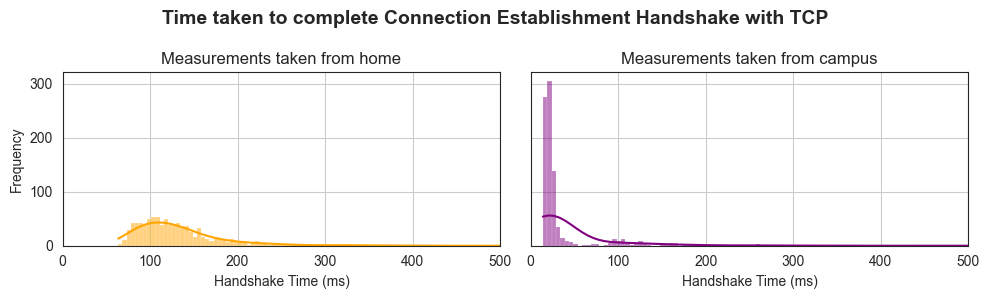

Number of sites with 3 TLS-related packets:
1
Number of sites with 1 TLS-related packets:
56
Number of sites with 2 TLS-related packets:
62


In [72]:
#pprint.pprint(handshake_times)
generateHandshakeTimeDistribution(handshake_times_tcp, 2, title="Time taken to complete Connection Establishment Handshake with TCP")

tls_data = {}

for location in tls_packets:
    for folder, tls_pkts in tls_packets[location].items():
        if tls_pkts != None:
            num_packets = len(tls_pkts)
            if num_packets in tls_data:
                tls_data[num_packets] += 1
            else:
                tls_data[num_packets] = 1

for k, v in tls_data.items():
    print(f"Number of sites with {k} TLS-related packets:")
    print(v)